In [1]:
!pip install yfinance


In [2]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()


In [3]:
import yfinance as yf
from datetime import date

end_date = date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

df = yf.download('AAPL', start=start_date, end=end_date)

# Inspect the data
print(df.head())
print(df.info())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
1990-01-02  0.261841  0.263599  0.246026  0.247783  183198400
1990-01-03  0.263599  0.267114  0.263599  0.267114  207995200
1990-01-04  0.264478  0.272385  0.261841  0.268871  221513600
1990-01-05  0.265357  0.268871  0.260084  0.265357  123312000
1990-01-08  0.267114  0.267114  0.260084  0.263599  101572800
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8856 entries, 1990-01-02 to 2025-02-28
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   8856 non-null   float64
 1   (High, AAPL)    8856 non-null   float64
 2   (Low, AAPL)     8856 non-null   float64
 3   (Open, AAPL)    8856 non-null   float64
 4   (Volume, AAPL)  8856 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 415.1 KB
None


In [4]:
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

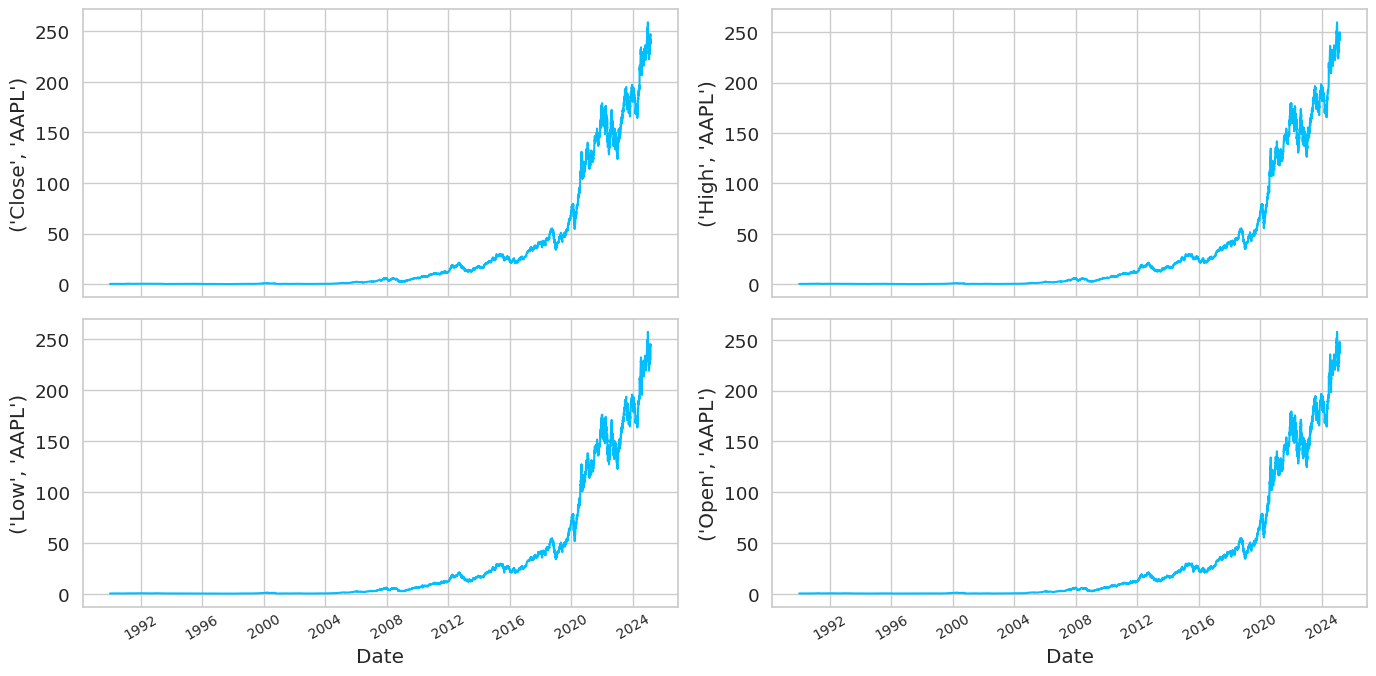

In [5]:
import matplotlib.dates as mdates

def data_plot(df):
    # Plot line charts
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

# Plot the data
data_plot(df)


In [6]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ensure MultiIndex is handled correctly
print(df.columns)  # Check structure

# Solution 1: Access the "Open" price for AAPL
train_data = df[:math.ceil(len(df) * 0.8)][('Open', 'AAPL')]
test_data = df[math.ceil(len(df) * 0.8):][('Open', 'AAPL')]

print(train_data.shape, test_data.shape)

# Convert to NumPy arrays
dataset_train = train_data.values.reshape(-1, 1)
dataset_test = test_data.values.reshape(-1, 1)

print(dataset_train.shape, dataset_test.shape)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.transform(dataset_test)  # Use transform, not fit_transform
print(scaled_test[:5])


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
(7085,) (1771,)
(7085, 1) (1771, 1)
[[0.00358873]
 [0.0040484 ]
 [0.00409018]
 [0.00400661]
 [0.00396481]]
[[0.90634836]
 [0.91246419]
 [0.95033602]
 [0.96475568]
 [0.96301628]]


In [7]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)


torch.Size([7035, 50, 1]) torch.Size([7035, 1])
torch.Size([1741, 30, 1]) torch.Size([1741, 1])


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 32  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


cuda
Epoch [10/100] - Training Loss: 0.0003, Test Loss: 3.9526
Epoch [20/100] - Training Loss: 0.0001, Test Loss: 5.2911
Epoch [30/100] - Training Loss: 0.0001, Test Loss: 5.4497
Epoch [40/100] - Training Loss: 0.0001, Test Loss: 5.3766
Epoch [50/100] - Training Loss: 0.0001, Test Loss: 5.1700
Epoch [60/100] - Training Loss: 0.0001, Test Loss: 5.1905
Epoch [70/100] - Training Loss: 0.0001, Test Loss: 4.8002
Epoch [80/100] - Training Loss: 0.0001, Test Loss: 4.7416
Epoch [90/100] - Training Loss: 0.0001, Test Loss: 4.6738
Epoch [100/100] - Training Loss: 0.0001, Test Loss: 4.8742


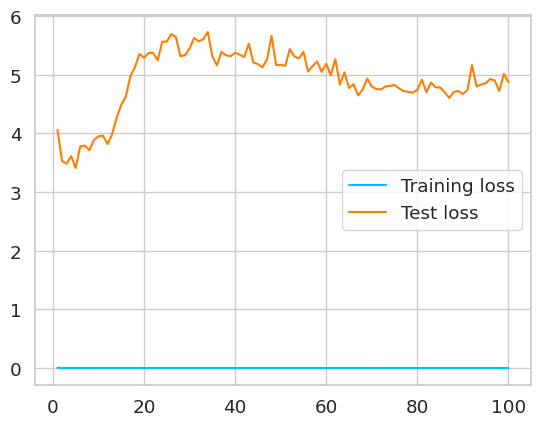

In [9]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()


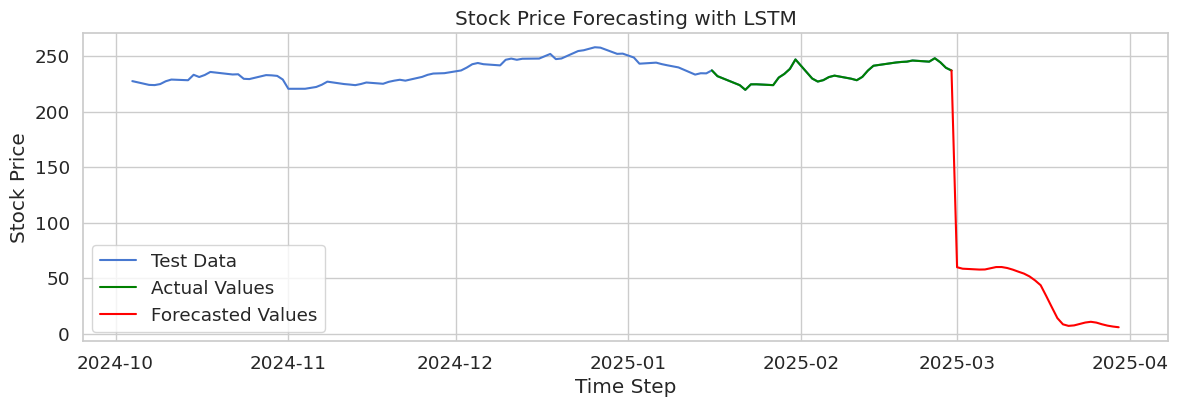

RMSE: 2.1736
R² Score: -1.3292


In [11]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

# Get last date from the test data index
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=num_forecast_steps)

# Plot Results
plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.values[-100:], label="Test Data", color="b")
plt.plot(test_data.index[-30:], test_data.values[-30:], label='Actual Values', color='green')
plt.plot(test_data.index[-1:].append(future_dates),
         np.concatenate([test_data.values[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]),
         label='Forecasted Values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Stock Price Forecasting with LSTM')
plt.grid(True)
plt.show()

# Evaluate Model Performance
test_predictions = []
model.eval()
with torch.no_grad():
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.unsqueeze(0).to(device)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')
